## Predict sentiment score of cryptocurrencies c with Fedot.Industrial

By combining historical sentiment data for 4 cryptocurrencies, extracted from EODHistoricalData31 and made available, with historical price data for the same cryptocurrencies, extracted from CryptoDataDownload32, was created the **BitcoinSentiment, EthereumSentiment, CardanoSentiment, and BinanceCoinSentiment** datasets, with 332, 356, 107, and 263 total instances, respectively. In all four datasets, the **predictors** are hourly **close price (in USD)** and **traded volume** for each respective cryptocurrency during a day, resulting in 2-dimensional time series of length 24. The **target variable** is the **normalized sentiment score** on the day spanned by the timepoints. The datasets were split
into train and test sets by randomly selecting 30% of each set as test data.
Link to the dataset - https://www.kaggle.com/datasets/gautamchettiar/historical-sentiment-data-btc-eth-bnb-ada

In [1]:
import pandas as pd
from fedot_ind.api.utils.path_lib import PROJECT_PATH
from fedot.core.pipelines.pipeline_builder import PipelineBuilder
from fedot_ind.tools.loader import DataLoader
from fedot_ind.api.main import FedotIndustrial

In [2]:
def evaluate_loop(api_params, finetune: bool = False):
    industrial = FedotIndustrial(**api_params)
    if finetune:
        industrial.finetune(train_data)
    else:
        industrial.fit(train_data)
    return industrial

In [3]:
initial_assumption = PipelineBuilder().add_node('quantile_extractor').add_node('treg')
params = dict(problem='regression',
                             metric='rmse',
                             timeout=15,
                             initial_assumption=initial_assumption,
                             n_jobs=2,
                             logging_level=20)
dataset_name = 'BitcoinSentiment'
data_path = PROJECT_PATH + '/examples/data'

Now we must download the dataset. It could be done by using `DataReader` class that implemented as attribute of `FedotIndustrial` class. This class firstly tries to read the data from local project folder `data_path` and then if it is not possible, it downloads the data from the UCR/UEA archive. The data will be saved in the `data` folder.

In [4]:
_, train_data, test_data = DataLoader(dataset_name=dataset_name).read_train_test_files(
            dataset_name=dataset_name,
            data_path=data_path)

2024-04-04 13:59:55,515 - Reading data from D:\WORK\Repo\Industiral\IndustrialTS/examples/data/BitcoinSentiment


In [5]:
import numpy as np
features = np.array(train_data[0].values.tolist()).astype(float)

Lets check our data.

In [6]:
features.shape

(232, 2, 24)

Lets visualise our predictors.

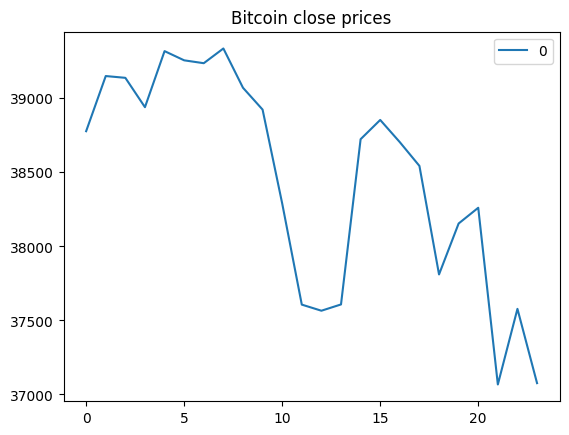

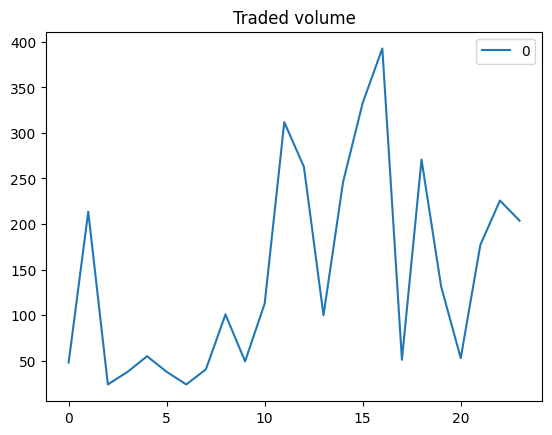

In [7]:
from matplotlib import pyplot as plt
pd.DataFrame(features[1, 0, :]).plot(title='Bitcoin close prices')
pd.DataFrame(features[1, 1, :]).plot(title='Traded volume')
plt.show()

Next steps are quite straightforward. We need to fit the model and then predict the values for the test data just like for any other model in sklearn.

At the `fit` stage FedotIndustrial will transform initial time series data into features dataframe and will train regression model.

In [8]:
industrial_model =  evaluate_loop(api_params=params, finetune=True)

2024-04-04 14:01:15,534 - Initialising experiment setup
2024-04-04 14:01:15,537 - Initialising Industrial Repository
2024-04-04 14:01:15,680 - Initialising Dask Server
Creating Dask Server
2024-04-04 14:01:16,655 - To route to workers diagnostics web server please install jupyter-server-proxy: python -m pip install jupyter-server-proxy
2024-04-04 14:01:16,697 - State start
2024-04-04 14:01:17,088 -   Scheduler at: inproc://10.64.4.217/10940/1
2024-04-04 14:01:17,089 -   dashboard at:  http://10.64.4.217:54878/status
2024-04-04 14:01:17,090 - Registering Worker plugin shuffle
2024-04-04 14:01:17,476 -       Start worker at: inproc://10.64.4.217/10940/4
2024-04-04 14:01:17,477 -          Listening to:          inproc10.64.4.217
2024-04-04 14:01:17,478 -           Worker name:                          0
2024-04-04 14:01:17,479 -          dashboard at:          10.64.4.217:54879
2024-04-04 14:01:17,480 - Waiting to connect to: inproc://10.64.4.217/10940/1
2024-04-04 14:01:17,481 - --------

[I 2024-04-04 14:07:36,572] A new study created in memory with name: no-name-5422bfa7-6741-4510-b7c0-5df5976a80f3


  0%|          | 0/200 [00:00<?, ?it/s]

[I 2024-04-04 14:07:41,591] Trial 3 finished with value: 0.24084665252738427 and parameters: {'0 || treg | max_features': 0.5176256863605868, '0 || treg | min_samples_split': 14, '0 || treg | min_samples_leaf': 18, '0 || treg | bootstrap': True}. Best is trial 3 with value: 0.24084665252738427.
[I 2024-04-04 14:07:44,391] Trial 2 finished with value: 0.242743749408413 and parameters: {'0 || treg | max_features': 0.34681219340349284, '0 || treg | min_samples_split': 7, '0 || treg | min_samples_leaf': 21, '0 || treg | bootstrap': True}. Best is trial 3 with value: 0.24084665252738427.
[I 2024-04-04 14:07:44,702] Trial 0 finished with value: 0.17652749301020135 and parameters: {'0 || treg | max_features': 0.9982491860406634, '0 || treg | min_samples_split': 14, '0 || treg | min_samples_leaf': 5, '0 || treg | bootstrap': False}. Best is trial 0 with value: 0.17652749301020135.
[I 2024-04-04 14:07:45,018] Trial 4 finished with value: 0.2423276453090087 and parameters: {'0 || treg | max_feat

In [9]:
labels = industrial_model.predict(test_data)
metrics = industrial_model.get_metrics(target=test_data[1],
                                 rounding_order=3,
                                 metric_names=('r2', 'rmse', 'mae'))

At the end of the experiment we can obtain the desired metric values using `calculate_regression_metric` method. Now there are five available metrics for classification task:
- `explained_variance_score`
- `max_error`
- `mean_absolute_error`
- `mean_squared_error`
- `d2_absolute_error_score`.
- `median_absolute_error`
- `r2_score`

In [10]:
metrics

,r2,rmse,mae
0,0.301,0.228,0.15


## AutoML approach

In [11]:
industrial_auto_model = evaluate_loop(api_params=params, finetune=False)

2024-04-04 15:04:38,857 - Initialising experiment setup
2024-04-04 15:04:38,860 - Initialising Industrial Repository
2024-04-04 15:04:38,862 - Initialising Dask Server
Creating Dask Server
2024-04-04 15:04:38,879 - State start
2024-04-04 15:04:39,260 -   Scheduler at: inproc://10.64.4.217/10940/9
2024-04-04 15:04:39,261 -   dashboard at:  http://10.64.4.217:55991/status
2024-04-04 15:04:39,262 - Registering Worker plugin shuffle
2024-04-04 15:04:39,647 -       Start worker at: inproc://10.64.4.217/10940/12
2024-04-04 15:04:39,648 -          Listening to:          inproc10.64.4.217
2024-04-04 15:04:39,648 -           Worker name:                          0
2024-04-04 15:04:39,649 -          dashboard at:          10.64.4.217:55994
2024-04-04 15:04:39,649 - Waiting to connect to: inproc://10.64.4.217/10940/9
2024-04-04 15:04:39,649 - -------------------------------------------------
2024-04-04 15:04:39,650 -               Threads:                          8
2024-04-04 15:04:39,650 -     

Generations:   0%|          | 0/10000 [00:00<?, ?gen/s]

2024-04-04 15:04:40,588 - IndustrialDispatcher - Number of used CPU's: 2
2024-04-04 15:04:48,616 - IndustrialDispatcher - 1 individuals out of 1 in previous population were evaluated successfully.
2024-04-04 15:04:48,669 - IndustrialEvoOptimizer - Generation num: 1 size: 1
2024-04-04 15:04:48,670 - IndustrialEvoOptimizer - Best individuals: HallOfFame archive fitness (1): ['<rmse=0.196 node_number=0.200>']
2024-04-04 15:04:49,643 - IndustrialDispatcher - Number of used CPU's: 2
2024-04-04 15:08:09,271 - IndustrialDispatcher - 21 individuals out of 21 in previous population were evaluated successfully.
2024-04-04 15:08:09,340 - IndustrialEvoOptimizer - Generation num: 2 size: 21
2024-04-04 15:08:09,341 - IndustrialEvoOptimizer - Best individuals: HallOfFame archive fitness (1): ['<rmse=0.194 node_number=0.300>']
2024-04-04 15:08:09,343 - IndustrialEvoOptimizer - Next population size: 21; max graph depth: 6
2024-04-04 15:08:13,820 - IndustrialDispatcher - Number of used CPU's: 2
2024-04-

Generations:   0%|          | 1/10000 [09:07<1520:18:26, 547.37s/gen]

2024-04-04 15:13:48,044 - IndustrialEvoOptimizer - Generation num: 3 size: 21
2024-04-04 15:13:48,047 - IndustrialEvoOptimizer - Best individuals: HallOfFame archive fitness (1): ['<rmse=0.187 node_number=0.500>']
2024-04-04 15:13:48,049 - GroupedCondition - Optimisation stopped: Time limit is reached


Generations:   0%|          | 1/10000 [09:07<1520:34:44, 547.46s/gen]

2024-04-04 15:13:48,053 - OptimisationTimer - Composition time: 9.124 min
2024-04-04 15:13:48,055 - OptimisationTimer - Algorithm was terminated due to processing time limit
2024-04-04 15:13:48,061 - IndustrialEvoOptimizer - Generation num: 4 size: 1
2024-04-04 15:13:48,070 - IndustrialEvoOptimizer - Best individuals: HallOfFame archive fitness (1): ['<rmse=0.187 node_number=0.500>']
2024-04-04 15:13:48,073 - IndustrialEvoOptimizer - no improvements for 1 iterations
2024-04-04 15:13:48,075 - IndustrialEvoOptimizer - spent time: 9.1 min
2024-04-04 15:13:48,083 - GPComposer - GP composition finished
2024-04-04 15:13:48,088 - DataSourceSplitter - Stratificated splitting of data is disabled.
2024-04-04 15:13:48,090 - DataSourceSplitter - Hold out validation is applied.
2024-04-04 15:13:48,103 - ApiComposer - Hyperparameters tuning started with 6 min. timeout
2024-04-04 15:13:48,108 - SimultaneousTuner - Hyperparameters optimization start: estimation of metric for initial graph


2024-04-04 15:14:16,975 - SimultaneousTuner - Initial graph: {'depth': 3, 'length': 5, 'nodes': [treg, quantile_extractor, fourier_basis, channel_filtration, wavelet_basis]}
treg - {}
quantile_extractor - {}
fourier_basis - {}
channel_filtration - {}
wavelet_basis - {} 
Initial metric: [0.194]
  0%|          | 0/100000 [00:00<?, ?trial/s, best loss=?]2024-04-04 15:14:17,058 - build_posterior_wrapper took 0.030917 seconds
2024-04-04 15:14:17,063 - TPE using 0 trials
  0%|          | 1/100000 [00:02<72:39:19,  2.62s/trial, best loss: 0.2139566555589375]2024-04-04 15:14:19,672 - build_posterior_wrapper took 0.028922 seconds
2024-04-04 15:14:19,683 - TPE using 1/1 trials with best loss 0.213957
  0%|          | 2/100000 [00:05<84:30:29,  3.04s/trial, best loss: 0.2139566555589375]2024-04-04 15:14:23,011 - build_posterior_wrapper took 0.026929 seconds
2024-04-04 15:14:23,020 - TPE using 2/2 trials with best loss 0.213957
  0%|          | 3/100000 [00:09<95:57:25,  3.45s/trial, best loss: 0.

ValueError: Probabilities of predictions are available only for classification

In [12]:
auto_labels = industrial_auto_model.predict(test_data)
auto_metrics = industrial_auto_model.get_metrics(target=test_data[1],
                                 rounding_order=3,
                                 metric_names=('r2', 'rmse', 'mae'))

In [13]:
auto_metrics

,r2,rmse,mae
0,0.348,0.22,0.141


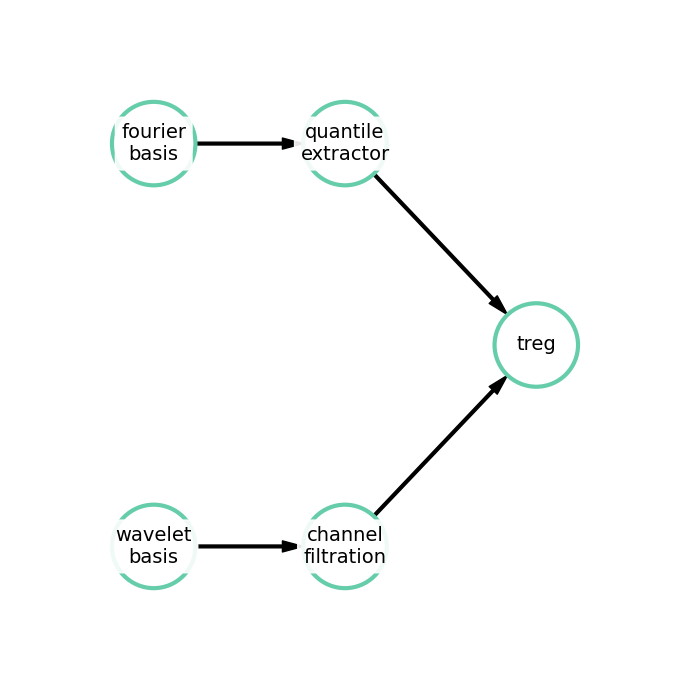

2024-04-04 15:20:22,532 - OperationsAnimatedBar - Visualizing optimization history... It may take some time, depending on the history size.
2024-04-04 15:20:22,803 - MovieWriter ffmpeg unavailable; using Pillow instead.
2024-04-04 15:20:22,804 - Animation.save using <class 'matplotlib.animation.PillowWriter'>
2024-04-04 15:20:36,222 - OperationsAnimatedBar - The animation was saved to "D:\WORK\Repo\Industiral\IndustrialTS\results_of_experiments\history_animated_bars.gif".
2024-04-04 15:20:36,224 - FitnessBox - Visualizing optimization history... It may take some time, depending on the history size.
2024-04-04 15:20:36,254 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-04-04 15:20:36,262 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the a

In [14]:
industrial_auto_model.solver.current_pipeline.show()
industrial_auto_model.plot_operation_distribution(mode='each')
industrial_auto_model.plot_fitness_by_generation()

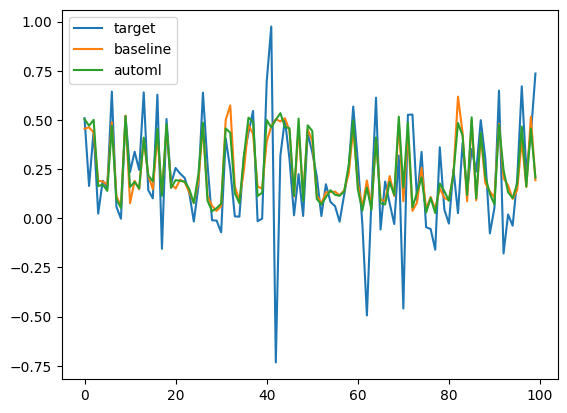

In [15]:
predictions = np.vstack([test_data[1].flatten(),labels.flatten(),auto_labels.flatten()]).T
all_prediction = pd.DataFrame(predictions,columns=['target','baseline','automl'])
all_prediction.plot()
plt.show()

2024-04-04 17:45:20,753 - FitnessBox - Visualizing optimization history... It may take some time, depending on the history size.
2024-04-04 17:45:21,494 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2024-04-04 17:45:21,546 - Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


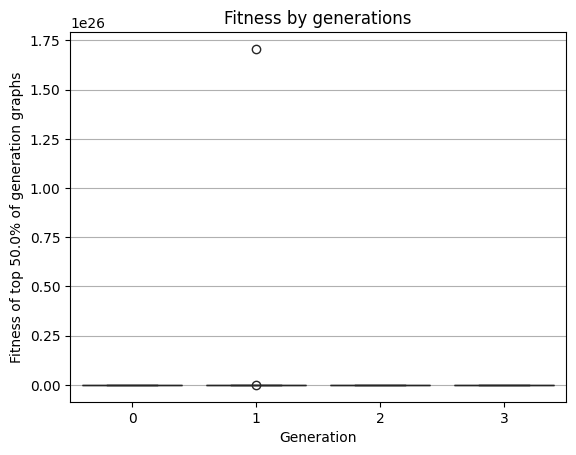

In [20]:
industrial_auto_model.solver.history.show.fitness_box(best_fraction=0.5, dpi=100)

In [23]:
industrial_auto_model.solver.return_report()

,days,hours,minutes,seconds,milliseconds
Data Definition (fit),0,0,0,0,1
Data Preprocessing,0,0,0,0,236
Fitting (summary),0,0,14,39,717
Composing,0,0,9,8,389
Train Inference,0,0,0,4,156
Tuning (composing),0,0,5,26,624
Tuning (after),0,0,0,0,0
Data Definition (predict),0,0,0,0,0
Predicting,0,0,0,2,474


2024-04-04 17:46:54,197 - OperationsKDE - Visualizing optimization history... It may take some time, depending on the history size.


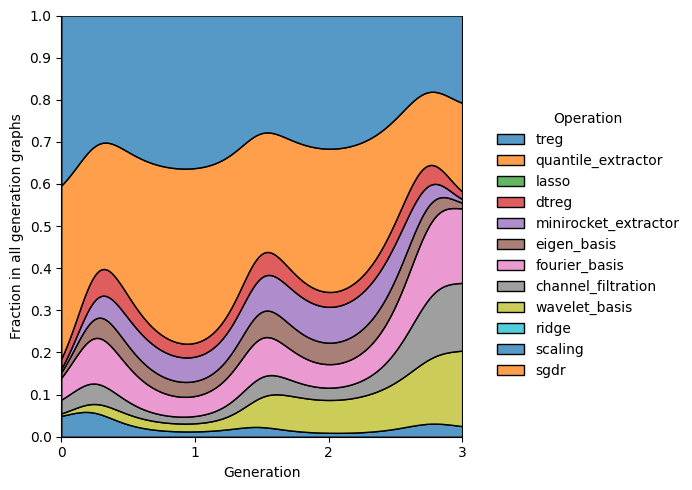

In [24]:
industrial_auto_model.solver.history.show.operations_kde(dpi=100)

## Compare with State of Art (SOTA) models

In [16]:
df = pd.read_csv(data_path+'/ts_regression_sota_results.csv',sep=';')
df = df[df['ds/type'] == dataset_name].iloc[:,:25]
df.index = df['algorithm']
df = df.drop(['algorithm','ds/type'], axis=1)
df = df.replace(',','.', regex=True).astype(float)

In [17]:
df['Fedot_Industrial_tuned'] = metrics['rmse'][0]
df['Fedot_Industrial_AutoML'] = auto_metrics['rmse'][0]
df = df.T

In [18]:
df.sort_values('max')['max']

Fedot_Industrial_AutoML    0.220000
RIST_RMSE                  0.227326
Fedot_Industrial_tuned     0.228000
RDST_RMSE                  0.233406
DrCIF_RMSE                 0.235080
RandF_RMSE                 0.235702
5NN-ED_RMSE                0.237231
5NN-DTW_RMSE               0.238461
FreshPRINCE_RMSE           0.242154
RotF_RMSE                  0.245572
XGBoost_RMSE               0.247072
TSF_RMSE                   0.247288
MultiROCKET_RMSE           0.252652
FCN_RMSE                   0.253077
InceptionT_RMSE            0.256789
FPCR_RMSE                  0.261870
ResNet_RMSE                0.266606
FPCR-Bs_RMSE               0.270278
SingleInception_RMSE       0.273212
1NN-DTW_RMSE               0.287127
Grid-SVR_RMSE              0.289215
CNN_RMSE                   0.289748
Ridge_RMSE                 0.303183
1NN-ED_RMSE                0.308109
ROCKET_RMSE                0.322641
Name: max, dtype: float64

In [19]:
df.sort_values('average')['average']

DrCIF_RMSE                 0.197055
RandF_RMSE                 0.199306
FreshPRINCE_RMSE           0.201173
RotF_RMSE                  0.201431
RDST_RMSE                  0.202498
RIST_RMSE                  0.202756
MultiROCKET_RMSE           0.204024
5NN-ED_RMSE                0.207243
5NN-DTW_RMSE               0.207365
XGBoost_RMSE               0.208650
TSF_RMSE                   0.209727
FPCR_RMSE                  0.211556
FPCR-Bs_RMSE               0.215564
InceptionT_RMSE            0.218467
Fedot_Industrial_AutoML    0.220000
FCN_RMSE                   0.220598
SingleInception_RMSE       0.224385
ResNet_RMSE                0.226852
Fedot_Industrial_tuned     0.228000
Ridge_RMSE                 0.232403
CNN_RMSE                   0.246243
Grid-SVR_RMSE              0.246649
1NN-DTW_RMSE               0.260328
1NN-ED_RMSE                0.264244
ROCKET_RMSE                0.268838
Name: average, dtype: float64